# Building a CG Model of the Miniprotein Chignolin

Chignolin is a miniprotein that is ten amino acids in length. The variant CLN025 in particular shows three metastable molecular states, corresponding to folded, misfolded, and unfolded conformations. To build a CG force field for coarse grain molecular dynamics through force matching, we must first download and prepare a dataset in order to train our neural network. The dataset that we choose is composed of 3744 all-atom simulations of CLN025 at 350K using CHARMM22* via an adaptive sampling strategy. The data is publicly available at http://pub.htmd.org/chignolin_trajectories.tar.gz .

For convenience, we have provided an example `torch_geometric.data.InMemoryDataset` class that automatically downloads, unzips, and organizes the data. Once the data is organized, the all-atom
coordinates and forces are mapped to a 10 bead carbon alpha coarse grained representation. Using the mapped coordinate data, a baseline prior model according to [CGSchNet Ref] is parametetrized
and used to subtract baseline coarse grain forces from the total coarse grain forces. The resulting "delta forces" can then be used as supervised learning targets for training coarse grain force
field models through force matching.



## Loading the CLN025 Dataset

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import sys

In [2]:
sys.path.insert(0, "../../")
from mlcg.datasets import ChignolinDataset
from mlcg.geometry import get_connectivity_matrix

To download and process the data, we supply a path when instantiating the dataset. The coordinates, forces, topology, and other important information will be organized and stored in this directory. in total, the dataset is about ~7 GB:

In [3]:
root = "PATH/TO/STORE/THE/DATASET"
root = "/net/data02/nickc/mlcg_cln"
# root = "/local_scratch/musil/datasets/test"
dataset = ChignolinDataset(root)

With the dataset downloaded and processed, we can take a closer look:

In [4]:
print("CG mapped data:\n\n", dataset.data)

CG mapped data:

 AtomicData(
  out={},
  pos=[18688610, 3],
  traj_id=[1868861],
  frame_id=[1868861],
  atom_types=[18688610],
  n_atoms=[1868861],
  masses=[18688610],
  forces=[18688610, 3],
  neighbor_list={}
)


Altogether, we have an aggregate ~1.8M frames of trajectory data (for both coordinates and forces). The collated data also contains information about the masses and the neighborlists associated with the features of the baseline/prior model (see below). We can also visualize how the different CG beads are typed. `mlcg.geometry.topology` contains several useful tools for graph related operations. Here, we use `get_connectivity_matrix` to generate a connectivity/adjacency matrix associated with the bonded structure of our CG mapping of Chignolin. This matrix can be used directly with `networkx`:

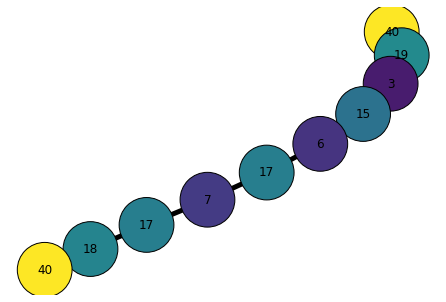

In [5]:
dataset.topologies.draw(
    layout_kwargs={"seed": 7},
    drawing_kwargs={"node_size": 3000, "width": 5, "edgecolors": "black"},
)

Here, we see that integer type have been assigned to each of the 10 carbon alpha atoms according to its amino acid identity, while allocating special types for the terminal TYR1 and TYR10 carbon alpha atoms. We can also inspect the baseline model that produced the delta forces that will be used for training the model describing the CG forcefeild:

In [6]:
print(dataset.prior_models)

ModuleDict(
  (bonds): GradientsOut(
    (model): HarmonicBonds()
  )
  (angles): GradientsOut(
    (model): HarmonicAngles()
  )
  (repulsion): GradientsOut(
    (model): Repulsion()
  )
)


We see that our baseline model contains three prior types, which are defined in `mlcg.nn.prior`: `HarmonicBonds` to constrain sequential carbon alpha pairs and `HarmonicAngles` to constrain sequential carbon alpha triplets along the molecular backbone. These two priors keep the CG molecule from breaking apart or becoming too flexible. The baseline model also employs a `Repulsion` prior to all non-bonded carbon alpha atoms, which helps to prevent distant parts of the CG molecule from overlapping or collapsing on itself.

## Training a Model 

With the dataset downloaded and processed, we can now build and train a model to predict CG forces and energies. For our model, we choose CGSchNet, based on [CGSchNet](https://doi.org/10.1063/5.0026133). CGSchNet is an extended version of the SchNet graph neural network architecture for CG molecular systems. It accepts coordinates (specifically pairwise distances) and CG atom types as model inputs, and predicts CG energies and cartesian forces that can later be used for generative CG simulation. 

To train the model, normally, we use PyTorch Lightning CLI, which removes training boiler plate code/scripts by using training and model parameters specified entirely in a configuration `YAML` file. If users wish to make more general models, or if they prefer to implement their own training routines, all neural network and prior utilities are contained in the `mlcg.nn` subpackage. Here, we explicitly build a model from scratch to showcase both structure and flexibility:

For a SchNet model, we must first choose our Radial basis and Cutoff functions for the filter generating network. For this example, we choose `ExpNormalBasis` based on the PhysNet-style RBFs introduced in [Physnet](https://doi.org/10.1021/acs.jctc.9b00181). Since this basis already contains a `CosineCutoff` envelope, we simply use `IdentityCutoff` for our cutoff function. We can directly visualize our basis using tools from `mlcg.nn.radial_basis`:

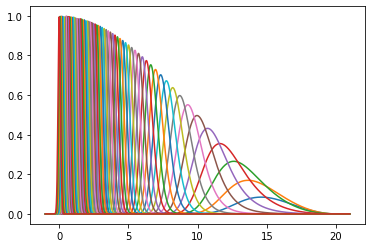

In [7]:
from mlcg.nn.radial_basis import ExpNormalBasis, visualize_basis
from mlcg.nn.cutoff import IdentityCutoff

cutoff_lower = 0.00
cutoff_upper = 20.00
num_rbf = 64

cutoff_fn = IdentityCutoff(cutoff_lower=cutoff_lower, cutoff_upper=cutoff_upper)
rbf_layer = ExpNormalBasis(
    cutoff_lower=cutoff_lower, cutoff_upper=cutoff_upper, num_rbf=64
)
visualize_basis(rbf_layer)

We can see that our basis offers higher filter resolution at smaller distances, while larger distances the filter resolution is more broad and the natural response is weaker. Next, we are ready to make our full SchNet enegy model. Although we have the freedom to assemble more modular constructions through the use of the `SchNet` class, we will instead use a convenient subclass called `StandardSchNet` that only needs a cutoff and an RBF layer. The remaining options can be specified through keyword arguments.

In [8]:
from mlcg.nn import StandardSchNet

schnet_params = {
    "max_num_neighbors": 50,
    "embedding_size": 44,
    "num_interactions": 3,
    "num_filters": 128,
    "hidden_channels": 128,
    "output_hidden_layer_widths": [128, 128],
    "activation": torch.nn.Tanh(),
    "aggr": "add",
}

energy_model = StandardSchNet(rbf_layer, cutoff_fn, **schnet_params)

Our SchNet model can predict scalar energies for each example/structure passsed to it in a batch of data. These energies are stored in the `out` field of an `AtomicData` instance that passes through the model. However, to train our model using force matching we must extract CG forces from the predicted CG energies through a gradient operation. To achieve this, we wrap our SchNet model with a `GradientsOut` model. `GradientsOut` simply requires an energy model and a list of prediction targets that can be acquired through gradient operations. In this case, we specify our gradient wrapper to calculate the CG forces. In pricple, any model can be wrapped by any operation, data outputs are always stored in `AtomicData.out`, so it is possible to retreive higher order gradients or transform the energy into other physical properties:

In [9]:
from mlcg.nn.gradients import GradientsOut

full_model = GradientsOut(energy_model, targets=["forces"])

Next, to train our model, we can use Pytorch Lighning utilities `PLModel` and `DataModule`, which handle optimization of the model parameters and migration of data from the dataset to the model respectively. The former requires a loss function and a pytorch optimizer class path. For the loss function, we choose `ForceRMSE`, which reports the root-mean-square error between predicted CG forces and reference forces. The `DataModule` accepts our Chignolin dataset instanced above. In order to save time, we stride the training data by a factor of 100 (though this will obviously result in reduced accuracy in the trained model):

In [10]:
# directory used to save training informations
TRAIN_PATH = "./train/"
!mkdir $TRAIN_PATH

mkdir: cannot create directory ‘./train/’: File exists


In [11]:
import pytorch_lightning as pl
from mlcg.nn.losses import ForceRMSE
from mlcg.pl import PLModel, DataModule

loss_fn = ForceRMSE("forces")
pl.seed_everything(12659843)
optimizer_dict = {"class_path": "torch.optim.Adam", "init_args": {"lr": 5e-4}}
lr_scheduler = {
    "class_path": "torch.optim.lr_scheduler.ReduceLROnPlateau",
    "init_args": {
        "factor": 0.9,
        "patience": 10,
        "min_lr": 1e-5,
    },
}
plmodel = PLModel(full_model, loss_fn, optimizer_dict, lr_scheduler)
dm = DataModule(dataset, log_dir=TRAIN_PATH, loading_stride=1000, num_workers=3)

Global seed set to 12659843


We can now combine our `PLModel` and `DataModule` by using the Pytorch Lightning `Trainer` object. `Trainer`can be supplied with callbacks, schedulers, etc. The `Trainer` can also take advantage of useful logging tools such as TensorBoard. For this example, we choose to train only using the CPU, but it is very simple to specify GPU training by chaning the `torch.device`.

In [12]:
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    dirpath=TRAIN_PATH,
    monitor="validation_loss",
    save_top_k=-1,  # -1 to save all
    every_n_epochs=1,
    filename="{epoch}-{validation_loss:.4f}",
    save_last=True,
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
early_stopping = EarlyStopping(
    monitor="validation_loss", patience=10, min_delta=5e-2
)
tb_logger = pl.loggers.TensorBoardLogger(
    TRAIN_PATH, name="tensorbord", version=""
)
csv_logger = pl.loggers.CSVLogger(TRAIN_PATH, name="", version="")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    devices=1,
    precision=32,
    auto_lr_find=False,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, lr_monitor, early_stopping],
    logger=[tb_logger, csv_logger],
    log_every_n_steps=1,
    reload_dataloaders_every_epoch=False,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/nickc/miniconda3/envs/mlcg/lib/python3.9/site-packages/pytorch_lightning-1.5.0rc1-py3.9.egg/pytorch_lightning/trainer/trainer.py:1481: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


We can begin training our model by calling the `Trainer.fit` method and supplying our `PLModel` and `DataModule`. For this demonstration, we do not include a validation set or a 

In [ ]:
from time import ctime

print(f"Starting training at {ctime()}")
trainer.fit(plmodel, dm)
print(f"Ending training at {ctime()}")

/home/nickc/miniconda3/envs/mlcg/lib/python3.9/site-packages/pytorch_lightning-1.5.0rc1-py3.9.egg/pytorch_lightning/trainer/configuration_validator.py:156: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")


Starting training at Mon Nov  8 15:10:01 2021


/home/nickc/miniconda3/envs/mlcg/lib/python3.9/site-packages/pytorch_lightning-1.5.0rc1-py3.9.egg/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory ./train/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | GradientsOut | 261 K 
1 | loss  | ForceRMSE    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.047     Total estimated model params size (MB)
/home/nickc/miniconda3/envs/mlcg/lib/python3.9/site-packages/pytorch_lightning-1.5.0rc1-py3.9.egg/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/nickc/local/mlcg-tools/examples/notebooks/train exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12659843


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We can inspect the results of our training according to our metrics:

## Using a Trained Model as a CG Force Feild

With our model trained, we can use its ability to predict forces as a component of a CG molecular dynamics simulation. Currently, we implement Langevin and overdamped Langevin simulation schemes - here we will test the practical performance of our trained model using a Langevin simulation. To run a simulation, we can instance the `LangevinSimulation` class defined in `mlcg.simulation` and set some parameters, such as the inverse temperature, the length of the simulation, the integration timstep, the dynamical friction, etc.

In [ ]:
SIM_PATH = "./simulate/"
!mkdir $SIM_PATH

In [ ]:
from mlcg.simulation import LangevinSimulation

n_timesteps = 10000
save_interval = 10
export_interval = 1000
log_interval = 1000
dt = 0.004
friction = 1.0
beta = dataset.beta
filename = "simulate/cln_model"

simulation = LangevinSimulation(
    friction,
    dt=dt,
    beta=beta,
    n_timesteps=n_timesteps,
    save_interval=save_interval,
    export_interval=export_interval,
    log_interval=log_interval,
    filename=filename,
)

Once the simulation has been set up, we must pass it a list of `AtomicData` containing the initial coordinates, atom types, and masses. For this demonstration, we select 10 random frames from the entire dataset. Because we are now simulating with priors, we must make sure to supply our `AtomicData`s with the poper neighbor list for each prior:


In [ ]:
prior_nls = {}
for model in dataset.priors_cls:
    prior_nls.update(**model.neighbor_list(dataset.topologies))

full_idx = np.arange(len(dataset))
chosen_idx = np.random.choice(full_idx, 10)

initial_data_list = []
for idx in chosen_idx:
    data = dataset.get(idx)
    data.neighbor_list = prior_nls
    initial_data_list.append(data)
print(initial_data_list[0])

Because our model was trained using delta forces, we must combine our trained model with the original baseline forces/priors in order to simulate physically meaningful resutls. To accomplish this, we can use the `SumOut` class defined in `mlcg.nn.gradients`. `SumOut` aggregates the properties predicted in `AtomicData.out` over multiple models. In this case, we want to combine our trained SchNet model with the priors that were used to define the original delta forces. For simplicity, we use a helper method from `mlcg.pl` produce our model for simulation, but in principle `SumOut` can be used to combine arbitrary models together - once again taking advantage of the fact that the output of each model is stored individually in `AtomicData.out` by model name.

In [ ]:
from mlcg.pl import merge_priors_and_checkpoint

model = merge_priors_and_checkpoint("train/last.ckpt", dataset.prior_models)
model

With the model and initial data ready, we can attach both to our simulation instance and run the simulation:

In [ ]:
simulation.attach_configurations(initial_data_list)
simulation.attach_model(model)

print(f"Starting simulation at {ctime()}")
cg_traj = simulation.simulate()
print(f"Ending simulation at {ctime()}")
print("simulation output:", cg_traj.shape)

We see that our output has a shape `(n_sims, n_saved_configurations, n_atoms, 3)`.With the training complete, our CG trajectory is ready for analysis via MDTraj or PyEmma tools. We suggest following the tutorials [Here](http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html) for analyzing free energy surfaces for high dimensional systems.